# Logistic Regression with Weighted Tfidf

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV,RandomizedSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.learning_curve import validation_curve
from sklearn.cross_validation import cross_val_score
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import TimeSeriesSplit
from sklearn import cross_validation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn import naive_bayes
from sklearn.metrics import classification_report,confusion_matrix
import gensim
import nltk

C:\Users\RAJAN SHRIVASTAVA\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\RAJAN SHRIVASTAVA\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\Users\RAJAN SHRIVASTAVA\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be rem

In [2]:
final_data=pd.read_csv('Amazon.csv')

# Sort the Data Based on the TimeStamp

In [3]:
final_data.sort_values('Time',ascending=True)
final_data.head()

,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


# Spliting the whole Dataset into Train and Test

In [4]:
tscv=TimeSeriesSplit(n_splits=2)
for train_index,test_index in tscv.split(final_data):
    print("Train:", train_index,"Test:", test_index)
    train_data,test_data = final_data.iloc[train_index],final_data.iloc[test_index]

Train: [     0      1      2 ..., 121388 121389 121390] Test: [121391 121392 121393 ..., 242778 242779 242780]
Train: [     0      1      2 ..., 242778 242779 242780] Test: [242781 242782 242783 ..., 364168 364169 364170]


In [5]:
reviews=train_data['Score']
reviews=reviews[0:70000]
train_data=train_data[0:70000]

In [6]:
test_review=test_data['Score']
test_review=test_review[0:30000]
test_data=test_data[0:30000]

# Converting Train and Test data into vector using Weighted-tfidf

In [7]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'isn', 's', 'no', "it's", 'in', 'don', "wasn't", 'couldn', 'me', 'am', 'and', 'below', 'about', 'hers', 'down', 'wouldn', 'being', 'my', 'over', 'during', "mightn't", 'has', 'each', 'further', 'mustn', 'own', 'can', 'some', 'this', 'm', 'been', 'the', 'be', 'shouldn', 'between', 'we', "haven't", 'while', "needn't", 'after', 'what', 'off', 'that', 'where', "wouldn't", 'only', 'have', 'who', 'into', 'to', 'against', 'for', 'once', 'hadn', 'are', 'yourself', 'i', 'nor', 'doesn', 'needn', 'so', "won't", 'above', 'is', 'again', 'if', "that'll", 'up', "you've", 'y', 'didn', 'an', 'o', 'ourselves', 'which', 'did', 'any', 'do', "you'll", 'those', 'most', 'will', 'himself', 'or', 'at', 'had', 'her', 'doing', 'ma', 'it', 'ain', "didn't", "hadn't", 'having', 'he', 'because', 'haven', 'aren', 'how', 'yourselves', "don't", 't', 'herself', 'itself', 'under', 'was', 'd', 'when', 'why', 'them', 'same', 'hasn', 'myself', 'until', 'should', 'here', 'him', 'there', "couldn't", "you're", "you'd", 'of', "

In [8]:
i=0
list_of_sent_train=[]
for sent in train_data['CleanText'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_train.append(filtered_sentence)

In [9]:
i=0
list_of_sent_test=[]
for sent in test_data['CleanText'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [10]:
w2v_model_train=gensim.models.Word2Vec(list_of_sent_train,min_count=5,size=50,workers=4)
w2v_model_test=gensim.models.Word2Vec(list_of_sent_test,min_count=5,size=50,workers=4)

In [11]:
tf_idf_vec=TfidfVectorizer()
train_tf_idf=tf_idf_vec.fit_transform(train_data['CleanText'].values)

In [12]:
tf_idf_feat=tf_idf_vec.get_feature_names()
train_idf_sent_vectors=[];
#Storing each review/sentence in the list
row=0;
for sent in list_of_sent_train:#for each review/sentence
    sent_vec=np.zeros(50)
    weight_sum=0
    for word in sent:
        try:
            vec=w2v_model_train.wv[word]
            tfidf=train_tf_idf[row,tf_idf_feat.index(word)]
            sent_vec +=(vec*tfidf)
            weight_sum +=tfidf
        except:
            pass
    sent_vec /= weight_sum
    train_idf_sent_vectors.append(sent_vec)
    #print(tf_idf_sent_vectors)
    row += 1   

C:\Users\RAJAN SHRIVASTAVA\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [13]:
train_idf_sent_vectors_array=np.array(train_idf_sent_vectors)

In [20]:
train_idf_sent_vectors_array=np.nan_to_num(train_idf_sent_vectors_array)

In [14]:
test_tf_idf=tf_idf_vec.fit_transform(test_data['CleanText'].values)

In [15]:
tf_idf_feat=tf_idf_vec.get_feature_names()
test_idf_sent_vectors=[];
#Storing each review/sentence in the list
row=0;
for sent in list_of_sent_test:#for each review/sentence
    sent_vec=np.zeros(50)
    weight_sum=0
    for word in sent:
        try:
            vec=w2v_model_test.wv[word]
            tfidf=test_tf_idf[row,tf_idf_feat.index(word)]
            sent_vec +=(vec*tfidf)
            weight_sum +=tfidf
        except:
            pass
    sent_vec /= weight_sum
    test_idf_sent_vectors.append(sent_vec)
    #print(tf_idf_sent_vectors)
    row += 1   

C:\Users\RAJAN SHRIVASTAVA\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [18]:
test_idf_sent_vectors_array=np.array(test_idf_sent_vectors)
test_idf_sent_vectors_array=np.nan_to_num(test_idf_sent_vectors_array)

# Data Preprocessing and Standardization the Train and Test Data

In [21]:
from sklearn.preprocessing import StandardScaler
standard_train_data=StandardScaler(copy=True,with_mean=False,with_std=True).fit_transform(train_idf_sent_vectors_array)
print(standard_train_data.shape)

(70000, 50)


In [22]:
standard_test_data=StandardScaler(copy=True,with_mean=False,with_std=True).fit_transform(test_idf_sent_vectors_array)
print(standard_test_data.shape)

(30000, 50)


# Find the optimal value of the alpha using GridSearch

In [23]:
tuned_parameter=[{'C':[10**-4,10**-3, 10**-2, 10**0, 10**2,10**3,10**4]}] 
model=GridSearchCV(LogisticRegression(),tuned_parameter,scoring='f1',cv=5,refit=True)
model.fit(standard_train_data,reviews)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'C': [0.0001, 0.001, 0.01, 1, 100, 1000, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

In [122]:
c=model.best_params_
c_grid=c['C']
c_grid

1

In [25]:
model.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [26]:
model.best_score_

0.9291096596774936

# Let's find the optimal value of the lambda using RandomSearchCV

In [87]:
tuned_parameter_ran={'C':sp_rand()} 
model_ran=RandomizedSearchCV(LogisticRegression(),tuned_parameter_ran,scoring='f1',cv=5,n_iter=100)

In [88]:
model_ran.fit(standard_train_data,reviews)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=100, n_jobs=1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000273E3BEF6D8>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring='f1', verbose=0)

In [123]:
c=model_ran.best_params_
c_random=c['C']
c_random

0.96152927117029308

In [90]:
model_ran.best_score_

0.9291022044503959

# Apply Logistic Regression using L1 Regularization having Best Parameter from GridSearch

In [28]:
lr=LogisticRegression(penalty='l1',C=c_grid)
lr.fit(standard_train_data,reviews)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# Prediction and Evaluation

In [29]:
prediction=lr.predict(standard_test_data)
print(classification_report(test_review,prediction))

             precision    recall  f1-score   support

          0       0.26      0.70      0.37      5026
          1       0.91      0.59      0.71     24974

avg / total       0.80      0.61      0.66     30000



In [30]:
confu_matrix=confusion_matrix(test_review,prediction)
print(confu_matrix)

[[ 3531  1495]
 [10289 14685]]


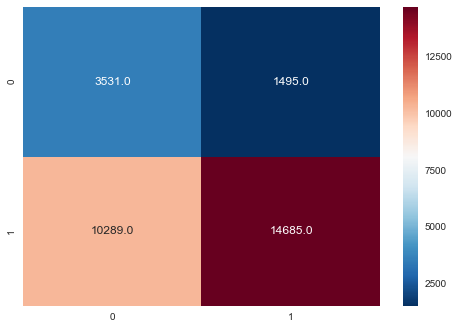

In [31]:
sns.heatmap(confu_matrix,annot=True,fmt='.1f',cmap='RdBu_r')
plt.show()

# Test and Train Metric

In [32]:
TP=confu_matrix[1][1]
FP=confu_matrix[0][1]
TN=confu_matrix[0][0]
FN=confu_matrix[1][0]

In [33]:
True_positive_rate=TP/(TP+FN) #It tells us when it is actually a Positive Review , How often does it predict Postive Review
print('TPR: ',True_positive_rate)

false_positive_rate=FP/(FP+TN) # It tells us that when the review is negative how often does it predict Positive Review
print('FPR: ',false_positive_rate)

specificity=TN/(TN+FP) #It tells us that When the review is negative ,how often does it predict negative review
print('Specificity: ',specificity)

precision=TP/(TP+FP) # It tells us all the reviews that model has predicted to be Positive how many are truly positive 
print('Precision: ',precision)

recall=TP/(TP+FN) # It tells us that from all the predicted postive reviews how many are actually postive review
print('Recall: ',recall)

f1_score=2*precision*recall/(precision+recall) #It is the weighted average of the Precision and Recall
print('F1Score: ',f1_score)

TPR:  0.588011531993
FPR:  0.297453243136
Specificity:  0.702546756864
Precision:  0.90760197775
Recall:  0.588011531993
F1Score:  0.713660883511


# ROC Curve

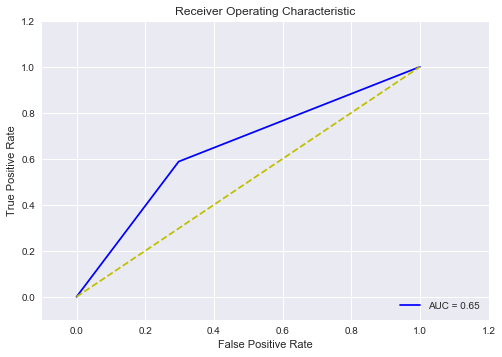

In [34]:
from sklearn.metrics import roc_curve,auc
fpr,tpr,thresholds=roc_curve(test_review,prediction)
roc_auc=auc(fpr,tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr,tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'y--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Apply Logistic Regression using L1 Regularization having Best Parameter from RandomSearch

In [99]:
lr_ran=LogisticRegression(penalty='l1',C=c_random)
lr_ran.fit(standard_train_data,reviews)

LogisticRegression(C=0.96152927117029308, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [100]:
prediction_ran=lr_ran.predict(standard_test_data)
print(classification_report(test_review,prediction_ran))

             precision    recall  f1-score   support

          0       0.26      0.70      0.37      5026
          1       0.91      0.59      0.71     24974

avg / total       0.80      0.61      0.66     30000



In [101]:
confu_matrix_l2_ran=confusion_matrix(test_review,prediction_ran)
print(confu_matrix_l2_ran)

[[ 3530  1496]
 [10288 14686]]


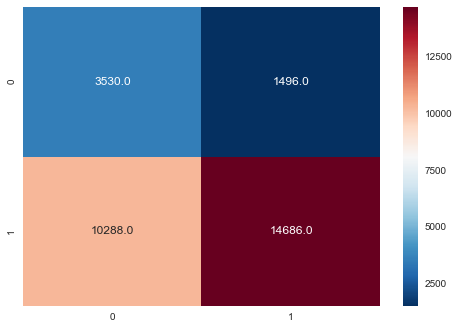

In [102]:
sns.heatmap(confu_matrix_l2_ran,annot=True,fmt='.1f',cmap='RdBu_r')
plt.show()

# Test and Train Metric

In [103]:
TP=confu_matrix_l2_ran[1][1]
FP=confu_matrix_l2_ran[0][1]
TN=confu_matrix_l2_ran[0][0]
FN=confu_matrix_l2_ran[1][0]

In [104]:
True_positive_rate=TP/(TP+FN) #It tells us when it is actually a Positive Review , How often does it predict Postive Review
print('TPR: ',True_positive_rate)

false_positive_rate=FP/(FP+TN) # It tells us that when the review is negative how often does it predict Positive Review
print('FPR: ',false_positive_rate)

specificity=TN/(TN+FP) #It tells us that When the review is negative ,how often does it predict negative review
print('Specificity: ',specificity)

precision=TP/(TP+FP) # It tells us all the reviews that model has predicted to be Positive how many are truly positive 
print('Precision: ',precision)

recall=TP/(TP+FN) # It tells us that from all the predicted postive reviews how many are actually postive review
print('Recall: ',recall)

f1_score=2*precision*recall/(precision+recall) #It is the weighted average of the Precision and Recall
print('F1Score: ',f1_score)

TPR:  0.588051573637
FPR:  0.297652208516
Specificity:  0.702347791484
Precision:  0.907551600544
Recall:  0.588051573637
F1Score:  0.713674798328


# ROc Curve

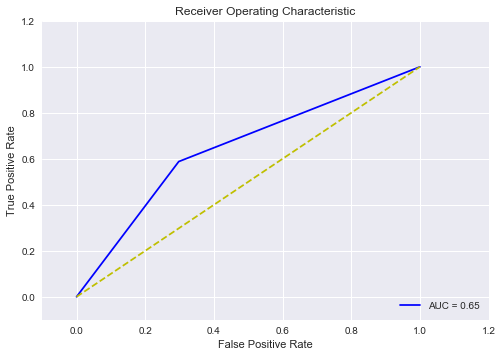

In [105]:
from sklearn.metrics import roc_curve,auc
fpr,tpr,thresholds=roc_curve(test_review,prediction_ran)
roc_auc=auc(fpr,tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr,tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'y--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Apply Logistic Regression using L2 Regularization having Best Parameter from GridSearch

In [106]:
lr_2=LogisticRegression(penalty='l2',C=c_grid)
lr_2.fit(standard_train_data,reviews)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# Prediction and Evaluation of L2 and GridSearch

In [107]:
prediction_l2=lr_2.predict(standard_test_data)
print(classification_report(test_review,prediction_l2))

             precision    recall  f1-score   support

          0       0.25      0.71      0.37      5026
          1       0.91      0.58      0.71     24974

avg / total       0.80      0.60      0.65     30000



In [108]:
confu_matrix_l2=confusion_matrix(test_review,prediction_l2)
print(confu_matrix_l2)

[[ 3551  1475]
 [10464 14510]]


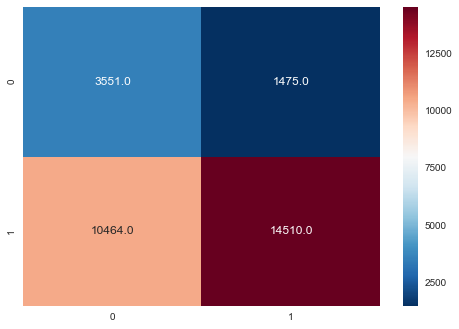

In [109]:
sns.heatmap(confu_matrix_l2,annot=True,fmt='.1f',cmap='RdBu_r')
plt.show()

# Test and Train Metric

In [110]:
TP=confu_matrix_l2[1][1]
FP=confu_matrix_l2[0][1]
TN=confu_matrix_l2[0][0]
FN=confu_matrix_l2[1][0]

In [111]:
True_positive_rate=TP/(TP+FN) #It tells us when it is actually a Positive Review , How often does it predict Postive Review
print('TPR: ',True_positive_rate)

false_positive_rate=FP/(FP+TN) # It tells us that when the review is negative how often does it predict Positive Review
print('FPR: ',false_positive_rate)

specificity=TN/(TN+FP) #It tells us that When the review is negative ,how often does it predict negative review
print('Specificity: ',specificity)

precision=TP/(TP+FP) # It tells us all the reviews that model has predicted to be Positive how many are truly positive 
print('Precision: ',precision)

recall=TP/(TP+FN) # It tells us that from all the predicted postive reviews how many are actually postive review
print('Recall: ',recall)

f1_score=2*precision*recall/(precision+recall) #It is the weighted average of the Precision and Recall
print('F1Score: ',f1_score)

TPR:  0.581004244414
FPR:  0.293473935535
Specificity:  0.706526064465
Precision:  0.907725993119
Recall:  0.581004244414
F1Score:  0.70851339144


# ROC curve

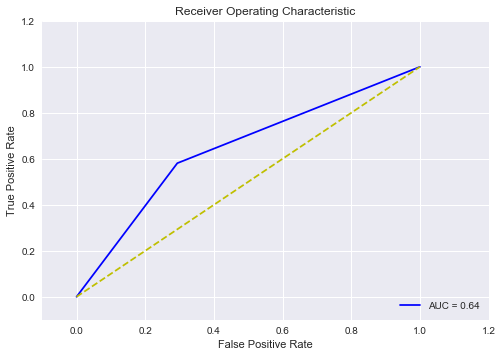

In [112]:
from sklearn.metrics import roc_curve,auc
fpr,tpr,thresholds=roc_curve(test_review,prediction_l2)
roc_auc=auc(fpr,tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr,tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'y--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Apply Logistic Regression using L2 Regularization having Best Parameter from RandomSearch

In [113]:
lr_2_ran=LogisticRegression(penalty='l2',C=c_grid)
lr_2_ran.fit(standard_train_data,reviews)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# Prediction and Evaluation

In [114]:
prediction_l2_ran=lr_2_ran.predict(standard_test_data)
print(classification_report(test_review,prediction_l2_ran))

             precision    recall  f1-score   support

          0       0.25      0.71      0.37      5026
          1       0.91      0.58      0.71     24974

avg / total       0.80      0.60      0.65     30000



In [115]:
confu_matrix_ran=confusion_matrix(test_review,prediction_l2_ran)
print(confu_matrix_ran)

[[ 3551  1475]
 [10464 14510]]


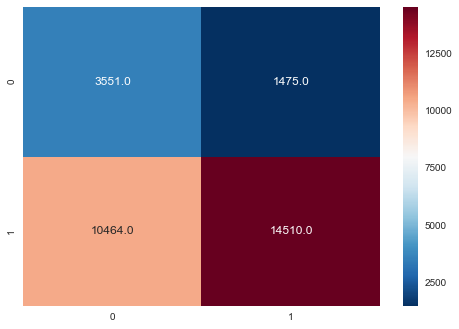

In [116]:
sns.heatmap(confu_matrix_ran,annot=True,fmt='.1f',cmap='RdBu_r')
plt.show()

# Test and Train Metric

In [117]:
TP=confu_matrix_ran[1][1]
FP=confu_matrix_ran[0][1]
TN=confu_matrix_ran[0][0]
FN=confu_matrix_ran[1][0]

In [118]:
True_positive_rate=TP/(TP+FN) #It tells us when it is actually a Positive Review , How often does it predict Postive Review
print('TPR: ',True_positive_rate)

false_positive_rate=FP/(FP+TN) # It tells us that when the review is negative how often does it predict Positive Review
print('FPR: ',false_positive_rate)

specificity=TN/(TN+FP) #It tells us that When the review is negative ,how often does it predict negative review
print('Specificity: ',specificity)

precision=TP/(TP+FP) # It tells us all the reviews that model has predicted to be Positive how many are truly positive 
print('Precision: ',precision)

recall=TP/(TP+FN) # It tells us that from all the predicted postive reviews how many are actually postive review
print('Recall: ',recall)

f1_score=2*precision*recall/(precision+recall) #It is the weighted average of the Precision and Recall
print('F1Score: ',f1_score)

TPR:  0.581004244414
FPR:  0.293473935535
Specificity:  0.706526064465
Precision:  0.907725993119
Recall:  0.581004244414
F1Score:  0.70851339144


# ROc Curve

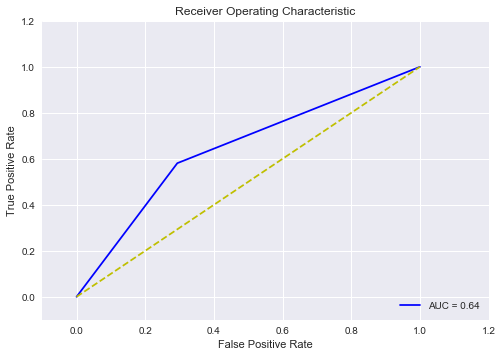

In [119]:
from sklearn.metrics import roc_curve,auc
fpr,tpr,thresholds=roc_curve(test_review,prediction_l2_ran)
roc_auc=auc(fpr,tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr,tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'y--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Checking the Sparsity with the increasing value of the lambda

In [44]:
C_param_range = [0.001,0.01,0.1,1,10,100]
for j in C_param_range:
    lr=LogisticRegression(penalty='l1',C=j,random_state=0)
    lr.fit(standard_train_data,reviews)
    w=lr.coef_
    print(np.count_nonzero(w))

20
46
50
50
50
50


The MSE on the different value of C [0.13995718322252215, 0.12785700358228791, 0.12648560357747751, 0.126071308677842, 0.12591416173848324]


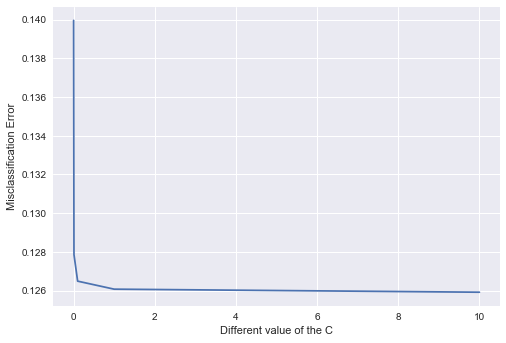

In [45]:
C_param_range = [0.001,0.01,0.1,1,10]
cv_score=[]
for j in C_param_range:
    lr=LogisticRegression(penalty='l1',C=j,random_state=0)
    scores=cross_val_score(lr,standard_train_data,reviews,cv=5,).mean()
    cv_score.append(scores)
    
# changing to misclassification error
MSE = [1 - x for x in cv_score]
print('The MSE on the different value of C', MSE)
plt.plot(C_param_range,MSE)
plt.xlabel('Different value of the C')
plt.ylabel('Misclassification Error')
plt.show()

# Feature Selection and Checking the Multicollinearity

# Adding the random Noise to the datasets

In [46]:
noise=np.random.normal(0,0.01,size=(70000,50))

In [47]:
standard_train_data_noise=standard_train_data + noise
print(standard_train_data_noise)

[[-0.79233784 -0.07149493 -0.02066298 ...,  0.18588372  0.3323919
  -0.08757356]
 [-0.14450932 -0.30907849 -0.43069244 ...,  0.24402095 -0.29876344
   0.3176258 ]
 [-1.4480338  -1.95505796  0.06244321 ...,  0.23091369  0.86997258
  -0.23661508]
 ..., 
 [-0.41155725 -0.13721836  1.02597372 ..., -1.47375229 -0.6497534
   1.14890297]
 [ 0.16982663 -0.06956368  1.02878038 ..., -0.83127521 -1.51513173
   1.57410831]
 [-0.50885215 -0.69682358  2.16516367 ..., -1.22194497 -1.53870537
   2.07803978]]


In [48]:
lr3=LogisticRegression(penalty='l2',C=c_grid)
lr3.fit(standard_train_data_noise,reviews)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# Prediction and Evaluation by Adding a Random Noise to the training DATA

In [49]:
prediction_l2_noise=lr3.predict(standard_test_data)
print(classification_report(test_review,prediction_l2_noise))

             precision    recall  f1-score   support

          0       0.25      0.71      0.37      5026
          1       0.91      0.58      0.71     24974

avg / total       0.80      0.60      0.65     30000



In [50]:
confu_noise=confusion_matrix(test_review,prediction_l2_noise)

In [51]:
print(confu_noise)

[[ 3552  1474]
 [10466 14508]]


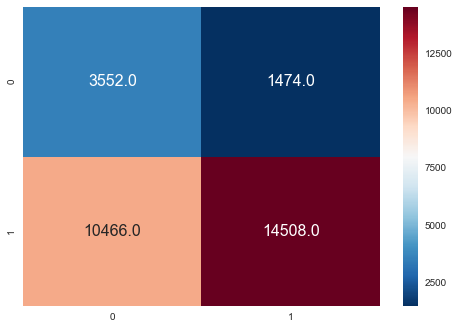

In [52]:
sns.heatmap(confu_noise,annot=True,fmt='.1f',annot_kws={"size": 16},cmap='RdBu_r')
plt.show()

In [53]:
w_hat=lr3.coef_

In [54]:
w_hat=np.array(w_hat)
print(w_hat)

[[-0.62656942 -0.63551295  0.13723054 -0.31490369 -0.64253928 -0.56570783
   0.24508832  0.00442988 -0.32607931 -0.02134423 -0.02893083  0.09489862
  -0.59018194  0.78496352  0.09244348 -0.13154181 -0.61123996  0.35974048
   0.25492268 -0.27738678  0.30818113 -0.02278377 -0.23165993 -0.05837895
   0.01202962  0.42079496 -0.04323282 -0.13332134  0.25572276 -0.28750201
   0.12686893 -0.55090109  0.24238453 -0.04514389 -0.62769335 -0.29924173
  -0.28943628  0.36915578 -0.17351834 -0.18154417  0.48157035 -0.08883165
  -0.3824593  -0.17125863 -0.04468127  0.20273022  0.04015523  0.01528648
  -0.12950156  0.37846224]]


In [71]:
w_old=lr_2.coef_
w_old=np.array(w_old)
print(w_old)
type(w_old)

[[-0.62764596 -0.63595261  0.13681734 -0.31521968 -0.64350624 -0.56501374
   0.24520764  0.0039191  -0.32595125 -0.0210242  -0.0295315   0.09605755
  -0.59071652  0.78302714  0.09217981 -0.13185078 -0.61131982  0.35942704
   0.25501257 -0.27579707  0.30840746 -0.02227191 -0.23017725 -0.05877787
   0.01047351  0.42106611 -0.04302591 -0.1332525   0.25636345 -0.28681798
   0.12614835 -0.54985082  0.24142492 -0.04569188 -0.62812945 -0.29852298
  -0.28932506  0.36871078 -0.17345617 -0.18131966  0.48057216 -0.08855188
  -0.38127404 -0.17123652 -0.04455926  0.20362544  0.03982363  0.01486579
  -0.12924048  0.37824462]]


numpy.ndarray

# Find the difference in both weight vectors before and after Noise

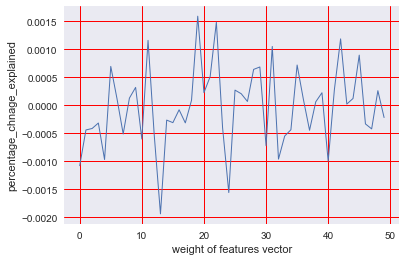

In [60]:
diff=[]
for i in range(w_hat.size):
    diff.append(w_old[:,i] - w_hat[:,i])

plt.figure(1,figsize=(6,4))
#plt.clf()
plt.plot(diff,linewidth=1)
plt.axis('tight')
plt.grid(color='r',linewidth=1,linestyle='-')
plt.xlabel('weight of features vector')
plt.ylabel('percentage_chnage_explained')
plt.show()   

In [61]:
percentage_var_explained=diff / np.sum(diff)
percenatge_change=np.cumsum(percentage_var_explained)

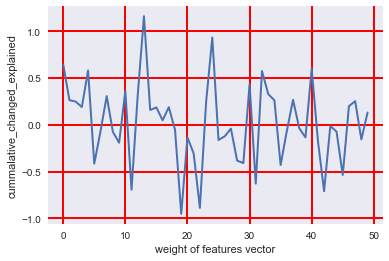

In [63]:
plt.figure(1,figsize=(6,4))
plt.clf()
plt.plot(percentage_var_explained,linewidth=2)
plt.axis('tight')
plt.grid(color='r',linewidth=2,linestyle='-')
plt.xlabel('weight of features vector')
plt.ylabel('cummalative_changed_explained')
plt.show()

In [81]:
w_old[0]

[-0.6276459618564517]

In [120]:
len(tf_idf_vec.get_feature_names()[0:50])

50

# Top ten features

In [121]:
import operator
top_features = {}
for i in range(len(tf_idf_vec.get_feature_names()[0:50])):
    top_features[tf_idf_vec.get_feature_names()[i]] = w_old[i]
top_features_sorted= sorted(top_features.items(), key = operator.itemgetter(1), reverse = True)
print("top 10 collinear feature:")
for i in range(10):
    print(top_features_sorted[i])

top 10 collinear feature:
('abandon', [0.783027135611783])
('aboutit', [0.4805721595610414])
('abl', [0.42106610755926976])
('abrupt', [0.3782446247721163])
('abouit', [0.36871077820011217])
('abbott', [0.3594270448775021])
('abdomin', [0.30840746045294937])
('ablt', [0.25636345171305164])
('abc', [0.2550125667976962])
('aafco', [0.24520763858330177])


# Observation/Summary 

1.I have preprocessed and cleaned  the whole dataset and store in Amazon.csv file for the further use. That CSV contains all the data. 
2. Now We have cleaned data , So I have sorted the Whole data on the basic of the TimeStamp
3. Now I have splitted my whole Dataset into Training and Test datasets for My ML
4. I have taken the 70K sample from the Training purpose and 30K Sample for Testing purpose
5. Its time to convert our text into vectors . I have used weighted tfidf to convert my text reviews into Vectors . 
   I have converted the Training Sample and Test sample individually

6. I have performed the column Standardization on my Training and Test data
7. I have tuned my gridSearch  With different parameter to find out the best parameter and best score. 
8. I have also tuned my random search to find out the best parameter and score. They are listed below


In [124]:
pd.DataFrame({'GridSearch':[0.9291,1],'RandomSearch':[0.9291,0.9695]},index=['Best_score','Best_parameter'])

,GridSearch,RandomSearch
Best_score,0.9291,0.9291
Best_parameter,1.0000,0.9695


8. We have the best Parameter.Now I have applied the Logistic Regression Using L1 and L2 Regularizer, taken the best parameter      got from the GridSearch. 

9. We have the best Parameter.Now I have applied the Logistic Regression Using L1 and L2 Regularizer, taken the best parameter      got from the RandomSearch. 
10. I have evaluated the Each one , In my case , The result I have got from the L2 regularization irrespective of GridSearch and     Random Search  is much better than in case of L1 regularization. 
11. I kept increasing the value of the lambda , and I have found that my misclassification error was kept on decreasing but at a     very high value lambda =1000 My misclassification error again increased  
12. As I have increased the lamda value to check the sparsity with a high value of lambda our mostly elements are zero as we        have decreased the lambda the sparsity decreased and We have got more non zero rows

13. Now I have checked the Multicollinearity, I have created a random noise of the same length as My datasets is . Now I have       remove the non zero rows to maintain the sparsity , Now I have added the Noise to the training dataset,I have my training       datasets with noise. 
14. Now I have applied by noise dataset to the logistic regression , Now I have calculated the new weight W_hat.
    What I have done , I have find the differnce between the w and w_hat, and plot it .
    In my case , most of the weight has not changed. there is hardly .02% change in the weight. So we can say that my features       are not Multicollinear. We have found the top ten features from the w 
    

    
